In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras import backend as K

In [ ]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Flatten the data
input_shape = (28, 28, 1)
x_train = np.reshape(x_train, [-1, np.prod(input_shape)])
x_test = np.reshape(x_test, [-1, np.prod(input_shape)])

# Set the hyperparameters
batch_size = 128
latent_dim = 2
epochs = 100


Epoch 1/100
469/469 [==============================] - 4s 4ms/step - loss: 204.9005 - val_loss: 175.4221
Epoch 2/100
469/469 [==============================] - 3s 5ms/step - loss: 170.8573 - val_loss: 167.9693
Epoch 3/100
469/469 [==============================] - 2s 4ms/step - loss: 166.3297 - val_loss: 164.9774
Epoch 4/100
469/469 [==============================] - 2s 4ms/step - loss: 164.0790 - val_loss: 163.5755
Epoch 5/100
469/469 [==============================] - 2s 4ms/step - loss: 162.5722 - val_loss: 162.0423
Epoch 6/100
469/469 [==============================] - 2s 4ms/step - loss: 161.4754 - val_loss: 161.3284
Epoch 7/100
469/469 [==============================] - 2s 4ms/step - loss: 160.5256 - val_loss: 160.7600
Epoch 8/100
469/469 [==============================] - 3s 6ms/step - loss: 159.7998 - val_loss: 160.0201
Epoch 9/100
469/469 [==============================] - 2s 4ms/step - loss: 159.1252 - val_loss: 159.6387
Epoch 10/100
469/469 [==============================] -

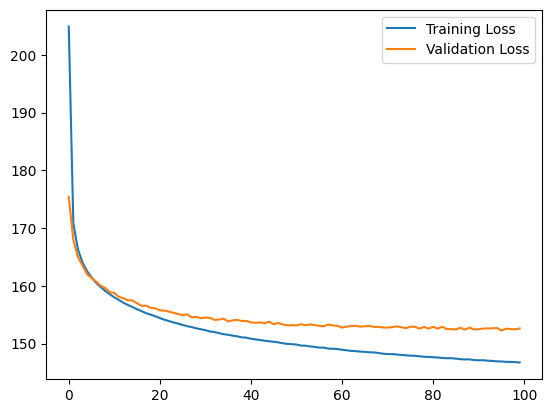

In [ ]:
# Define the encoder model
inputs = Input(shape=(784,))
x = Dense(256, activation='relu')(inputs)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

# Define the sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

# Define the decoder model
decoder_input = Input(shape=(latent_dim,))
x = Dense(256, activation='relu')(decoder_input)
outputs = Dense(784, activation='sigmoid')(x)
decoder = Model(decoder_input, outputs)

# Define the full VAE model
outputs = decoder(z)
vae = Model(inputs, outputs)

# Define the loss function
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= 784
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = -0.5 * K.sum(kl_loss, axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

# Compile the model
vae.compile(optimizer='adam')

# Train the model
history = vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))
vae.save("vae.h5")

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
x_test_reconstructed = vae.predict(x_test)

# Calculate the reconstruction error
reconstruction_error = np.mean(binary_crossentropy(x_test, x_test_reconstructed) * 784)

# Print the test error score
print("Test Error Score:", reconstruction_error)
plt.legend()
plt.show()



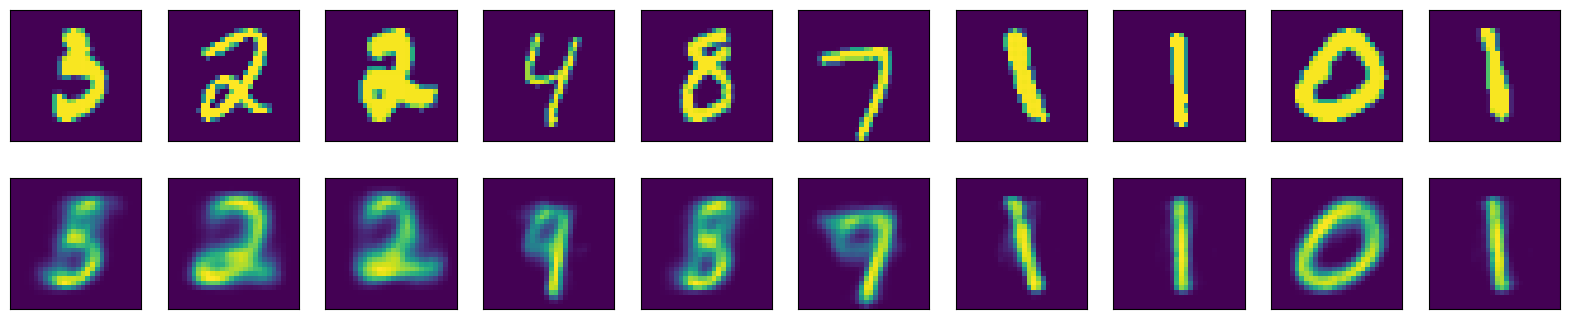

In [ ]:
n = 10
sample_indices = np.random.randint(0, x_test.shape[0], size=n)

# Plot the original images and their reconstructed versions
plt.figure(figsize=(20, 4))
for i, index in enumerate(sample_indices):
    # Plot the original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Plot the reconstructed image
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(x_test_reconstructed[index].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()